In [1]:
# includes
import os
import shutil
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import pickle

from data_handler import  add_noise_reaction_dict, calculate_calibration, add_noise_calibration, create_concentrations_dict, create_reaction_rates_dict, get_rates_and_concentrations , make_fitting_data
from parameter_estimator import estimate_parameters, monte_carlo_simulation

from simulator import cadet_simulation_full_system

from plotter import plot_monte_carlo_results, create_monte_carlo_report, plot_fitting_quality, plot_parameter_convergence, plot_component_analysis

**Reaktion 1:**

$$
v_{\text{obs,1}} = \frac{V_{\text{max,1}} \cdot [\text{NAD}] \cdot [\text{PD}]}{(K_{m,\text{PD}} + [\text{PD}]) \cdot (K_{m,\text{NAD}} + [\text{NAD}])}
$$

**Reaktion 2 (mit PD-Inhibition):**

$$
v_{\text{obs,2}} = \frac{V_{\text{max,2}} \cdot [\text{Lactol}] \cdot [\text{NADH}]}{\left(K_{m,\text{Lactol}} \left(1 + \frac{[\text{PD}]}{K_{i,\text{PD}}}\right) + [\text{Lactol}]\right) \cdot (K_{m,\text{NADH}} + [\text{NADH}])}
$$

**Reaktion 3:**

$$
v_{\text{obs,3}} = \frac{V_{\text{max,3}} \cdot [\text{Lactol}] \cdot [\text{NAD}]}{(K_{m,\text{Lactol}} + [\text{Lactol}]) \cdot (K_{m,\text{NAD}} + [\text{NAD}])}
$$

## 1. Lese Daten ein und erstelle Dataframe für weiterverarbeitung

- Die Daten für Reaktion 3 wurden aus CSV-Dateien eingelesen und als DataFrames (r3_lactol und r3_nad) gespeichert.
- Beide DataFrames enthalten Messwerte für verschiedene Konzentrationen von Lactol bzw. NAD.
- Zusätzlich sind die zugehörigen Rohdaten über die Zeit enthalten (mehrere Spalten mit Messwerten).
- Diese Daten bilden die Grundlage für die weitere Analyse und die spätere Parameterabschätzung im Workflow.

In [6]:
BASE_PATH = r"C:\Users\berger\Documents\Projekts\enzyme-cascade-analysis\Fehlerfortpflanzunganalyse"

calibration_data = pd.read_csv(os.path.join(BASE_PATH, 'Data', 'NADH_Kalibriergerade.csv'))
calibration_slope = calculate_calibration(calibration_data)

r1_path = os.path.join(BASE_PATH, 'Data', 'Reaction1')
r1_nad_data = pd.read_csv(os.path.join(r1_path, 'r_1_NAD_PD_500mM.csv'))
r1_pd_data = pd.read_csv(os.path.join(r1_path, 'r1_PD_NAD_5mM.csv'))


r2_path = os.path.join(BASE_PATH, 'Data', 'Reaction2')
r2_hp_data = pd.read_csv(os.path.join(r2_path, 'r_2_HP_NADH_06mM.csv'))
r2_nadh_data = pd.read_csv(os.path.join(r2_path, 'r_2_NADH_HP_300mM.csv'))
r2_pd_data = pd.read_csv(os.path.join(r2_path, 'r_2_PD_NADH_06mM_HP_300mM.csv'))

r3_path = os.path.join(BASE_PATH, 'Data', 'Reaction3')
r3_lactol = pd.read_csv(os.path.join(r3_path, 'r_3_Lactol_NAD_5mM.csv'))
r3_nad = pd.read_csv(os.path.join(r3_path, 'r_3_NAD_Lactol_500mM.csv'))


full_system_data = {
    "r1": {
        "c1": r1_nad_data,
        "c2": r1_pd_data
    },
    "r2": {
        "c1": r2_hp_data,
        "c2": r2_nadh_data,
        "c3": r2_pd_data
    },
    "r3": {
        "c1": r3_lactol,
        "c2": r3_nad
    }
}


full_system_param = {
    "r1": {
        "Vf_well": 10.0,
        "Vf_prod": 1.0,
        "c_prod": 2.2108,
        "c1_const": 5.0,
        "c2_const": 500.0
    },
    "r2": {
        "Vf_well": 10.0,
        "Vf_prod": 5.0,
        "c_prod": 2.15,
        "c1_const": 300.0,
        "c2_const": 0.6,
        "c3_const": 0.0
    },
    "r3": {
        "Vf_well": 10.0,
        "Vf_prod": 10.0,
        "c_prod": 2.15,
        "c1_const": 500.0,
        "c2_const": 5.0
    },
    "x_dimension": 3,
    "y_dimension": 1
}

full_system_dataframe = get_rates_and_concentrations(
    full_system_data,
    calibration_slope,  
    full_system_param
)

print("Anzahl der Datenpunkte pro Reaction")
print(full_system_dataframe["reaction"].value_counts())

full_system_dataframe.to_pickle(os.path.join(BASE_PATH, 'Data', 'full_system_dataframe.pkl'))
full_system_dataframe.to_csv(os.path.join(BASE_PATH, 'Data', 'full_system_dataframe.csv'))



Anzahl der Datenpunkte pro Reaction
reaction
2    40
3    36
1    28
Name: count, dtype: int64


## 2. Führe erste Parameter schätung druch
- Die Parameterabschätzung für das vollständige Reaktionssystem erfolgt mit den Daten aus allen drei Reaktionen.
- Die Funktion `estimate_parameters` nutzt die Modellbeschreibung und die experimentellen Daten (`df`), um die kinetischen Parameter zu bestimmen.
- Die initialen Schätzwerte und Grenzen für die Parameter sind im Modell-Info-Dictionary hinterlegt.
- Die Ergebnisse der Parameterschätzung werden für die weitere Analyse und Simulation verwendet.
- Die Rohdaten für Reaktion 3 (`r3_lactol`, `r3_nad`) enthalten Messwerte für verschiedene Substratkonzentrationen und Zeitpunkte und sind Teil der Auswertung.

In [3]:
def full_reaction_system(concentration_data, Vmax1, Vmax2, Vmax3, KmPD, KmNAD, KmLactol, KmNADH, KiPD):
    """
    Wrapper für curve_fit Kompatibilität - nimmt flache Parameter entgegen
    Berechnet die Enzymaktivität für das vollständige Drei-Reaktions-System
    
    ALLE DREI REAKTIONEN:
    - Reaktion 1: PD + NAD → Pyruvat + NADH
    - Reaktion 2: Lactol + NADH → ... (mit PD/NAD Inhibition)
    - Reaktion 3: Lactol + NAD → ... (mit Lactol Inhibition)
    """
    # Entpacke Substratkonzentrationen, Inhibitor-Konzentrationen und Reaktions-IDs
    S1, S2, Inhibitor, reaction_ids = concentration_data
    
    # Initialisiere Ergebnis-Array
    V_obs = np.zeros_like(S1, dtype=float)
    
    # Reaktion 1: PD + NAD → HD + NADH
    reaction_1_mask = (reaction_ids == 1)
    if np.any(reaction_1_mask):
        # S1 = NAD oder konstante NAD, S2 = PD oder konstante PD
        S1_r1 = S1[reaction_1_mask] # NAD
        S2_r1 = S2[reaction_1_mask] # PD
        
        V_obs[reaction_1_mask] = (Vmax1 * S1_r1 * S2_r1) / (
            (KmPD + S2_r1) *  (KmNAD + S1_r1)
        )
    
    # Reaktion 2: Lactol + NADH → ... (mit PD Inhibition)
    reaction_2_mask = (reaction_ids == 2)
    if np.any(reaction_2_mask):
        S1_r2 = S1[reaction_2_mask]  # Lactol
        S2_r2 = S2[reaction_2_mask]  # NADH
        PD_inhibitor = Inhibitor[reaction_2_mask]  # Variable PD-Konzentration als Inhibitor
        V_obs[reaction_2_mask] = (Vmax2 * S1_r2 * S2_r2) / (
            (KmLactol *(1 + PD_inhibitor / KiPD)  + S1_r2) * (KmNADH  + S2_r2)
        )
    # Reaktion 3: Lactol + NAD 
    reaction_3_mask = (reaction_ids == 3)
    if np.any(reaction_3_mask):
        S1_r3 = S1[reaction_3_mask]  # Lactol
        S2_r3 = S2[reaction_3_mask]  # NAD
        V_obs[reaction_3_mask] = (Vmax3 * S1_r3 * S2_r3) / (
            (KmLactol  + S1_r3) * (KmNAD + S2_r3)
        )
    
    return V_obs


full_reaction_system_model_info = {
    "name": "full_reaction_system",
    "function": full_reaction_system,
    "param_names": [
        "Vmax1", "Vmax2", "Vmax3",
        "KmPD", "KmNAD", "KmLactol", "KmNADH",
        "KiPD"
    ],
    "param_units": [
        "U", "U", "U",
        "mM", "mM", "mM", "mM",
        "mM"
    ],
    "substrate_keys": ["S1", "S2", "Inhibitor", "reaction_ids"],
    "initial_guess_func": lambda activities, substrate_data: [
        max(activities) if len(activities) > 0 else 1.0,  # Vmax1
        max(activities) if len(activities) > 0 else 1.0,  # Vmax2
        max(activities) if len(activities) > 0 else 1.0,  # Vmax3
        84.0,  # KmPD
        2.2,  # KmNAD
        75.0,  # KmLactol
        2.0,  # KmNADH
        90.0  # KiPD
    ],
    "bounds_lower": [0]*8,
    "bounds_upper": [np.inf]*8,
    "description": "Komplettes Drei-Reaktions-System mit Inhibitionen"
}

full_system_parameters = estimate_parameters(full_reaction_system_model_info, full_system_param,full_system_dataframe)

print("\n=== Parameter Schätzung für das vollständige System ==="
        f"\nModell: {full_reaction_system_model_info['description']}"
        f"\nR²: {full_system_parameters['r_squared']:.4f}")
for i, param_name in enumerate(full_reaction_system_model_info['param_names']):
    param_val = full_system_parameters['params'][i]
    param_err = full_system_parameters['param_errors'][i]
    unit = full_reaction_system_model_info['param_units'][i]
    print(f"{param_name}: {param_val:.4f} ± {param_err:.4f} {unit}")



=== Parameter Schätzung für das vollständige System ===
Modell: Komplettes Drei-Reaktions-System mit Inhibitionen
Ergebnis: {'success': True, 'params': array([9.05392422e-02, 7.09363578e+00, 2.88060189e+00, 9.83859896e+01,
       3.09131376e+00, 6.59684574e+01, 7.76490174e+00, 9.91007746e+01]), 'param_errors': array([4.48072104e-02, 1.70846091e+01, 1.00674472e-01, 1.93083514e+02,
       2.53385679e-01, 3.53747279e+00, 2.00482268e+01, 1.94117521e+01]), 'r_squared': np.float64(0.9928140198059497), 'model_name': 'full_reaction_system', 'description': 'Komplettes Drei-Reaktions-System mit Inhibitionen'}
R²: 0.9928
Vmax1: 0.0905 ± 0.0448 U
Vmax2: 7.0936 ± 17.0846 U
Vmax3: 2.8806 ± 0.1007 U
KmPD: 98.3860 ± 193.0835 mM
KmNAD: 3.0913 ± 0.2534 mM
KmLactol: 65.9685 ± 3.5375 mM
KmNADH: 7.7649 ± 20.0482 mM
KiPD: 99.1008 ± 19.4118 mM


### 3. Führe Monte Carlo Simulation durch

In [4]:
noise_level = {
    "calibration": 0.01,
    "reaction": 0.01,
}
simulation_dir = "Results/Simulations"

if os.path.exists(simulation_dir):
    shutil.rmtree(simulation_dir)
    print(f"Simulations-Ordner gelöscht: {simulation_dir}")

monte_carlo_results = monte_carlo_simulation(
    calibration_data,
    full_system_data,
    full_reaction_system_model_info,
    full_system_param,
    noise_level,
    n_iterations=100
)

create_monte_carlo_report(monte_carlo_results, full_reaction_system_model_info)



🔬 MONTE CARLO SIMULATION
Modell: Komplettes Drei-Reaktions-System mit Inhibitionen
Iterationen: 100
Kalibrierungs-Rauschen: 1.0%
Reaktions-Rauschen: 1.0%
🔄 Fortschritt:   5.0% (   5/100) | ✅ Erfolg:   5 (100.0%)
🔄 Fortschritt:  10.0% (  10/100) | ✅ Erfolg:  10 (100.0%)
🔄 Fortschritt:  15.0% (  15/100) | ✅ Erfolg:  15 (100.0%)
🔄 Fortschritt:  20.0% (  20/100) | ✅ Erfolg:  20 (100.0%)
🔄 Fortschritt:  25.0% (  25/100) | ✅ Erfolg:  25 (100.0%)
🔄 Fortschritt:  30.0% (  30/100) | ✅ Erfolg:  30 (100.0%)
🔄 Fortschritt:  35.0% (  35/100) | ✅ Erfolg:  35 (100.0%)
🔄 Fortschritt:  40.0% (  40/100) | ✅ Erfolg:  40 (100.0%)
🔄 Fortschritt:  45.0% (  45/100) | ✅ Erfolg:  45 (100.0%)
🔄 Fortschritt:  50.0% (  50/100) | ✅ Erfolg:  50 (100.0%)
🔄 Fortschritt:  55.0% (  55/100) | ✅ Erfolg:  55 (100.0%)
🔄 Fortschritt:  60.0% (  60/100) | ✅ Erfolg:  60 (100.0%)
🔄 Fortschritt:  65.0% (  65/100) | ✅ Erfolg:  65 (100.0%)
🔄 Fortschritt:  70.0% (  70/100) | ✅ Erfolg:  70 (100.0%)
🔄 Fortschritt:  75.0% (  75/100) 

## 4. Plotte Ergebnisse

### 4.1 Ergebnisse der Monte Carlo Simulation

📊 Plots gespeichert als: Results\monte_carlo_results.png


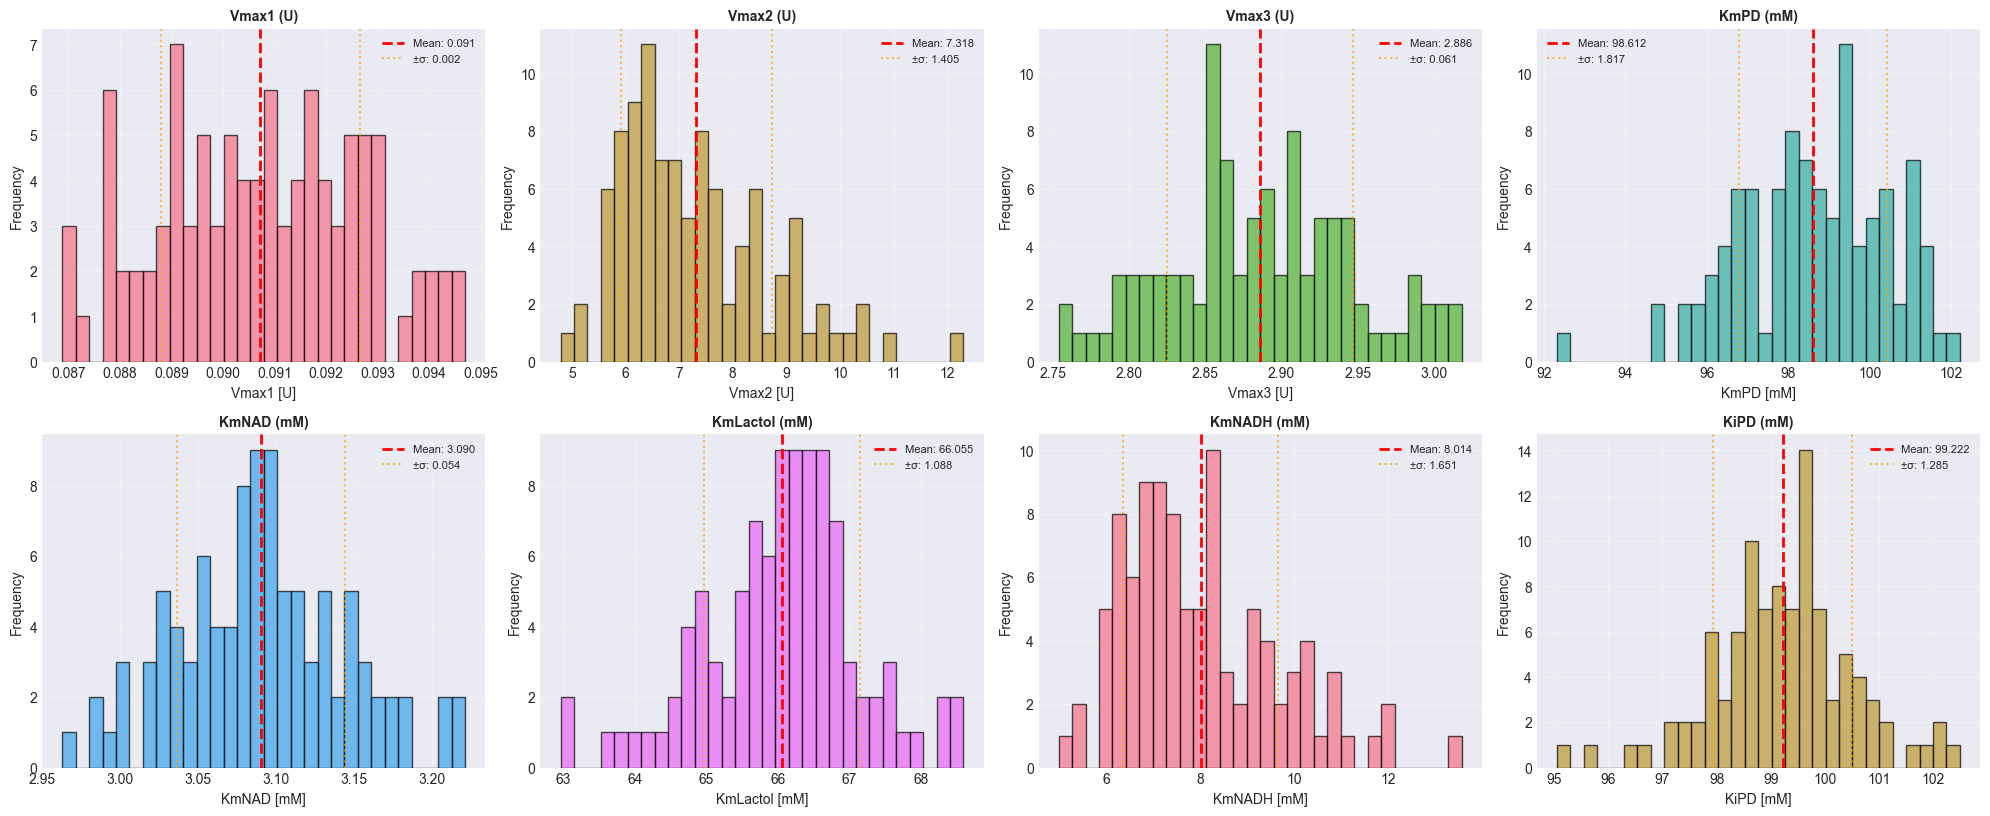

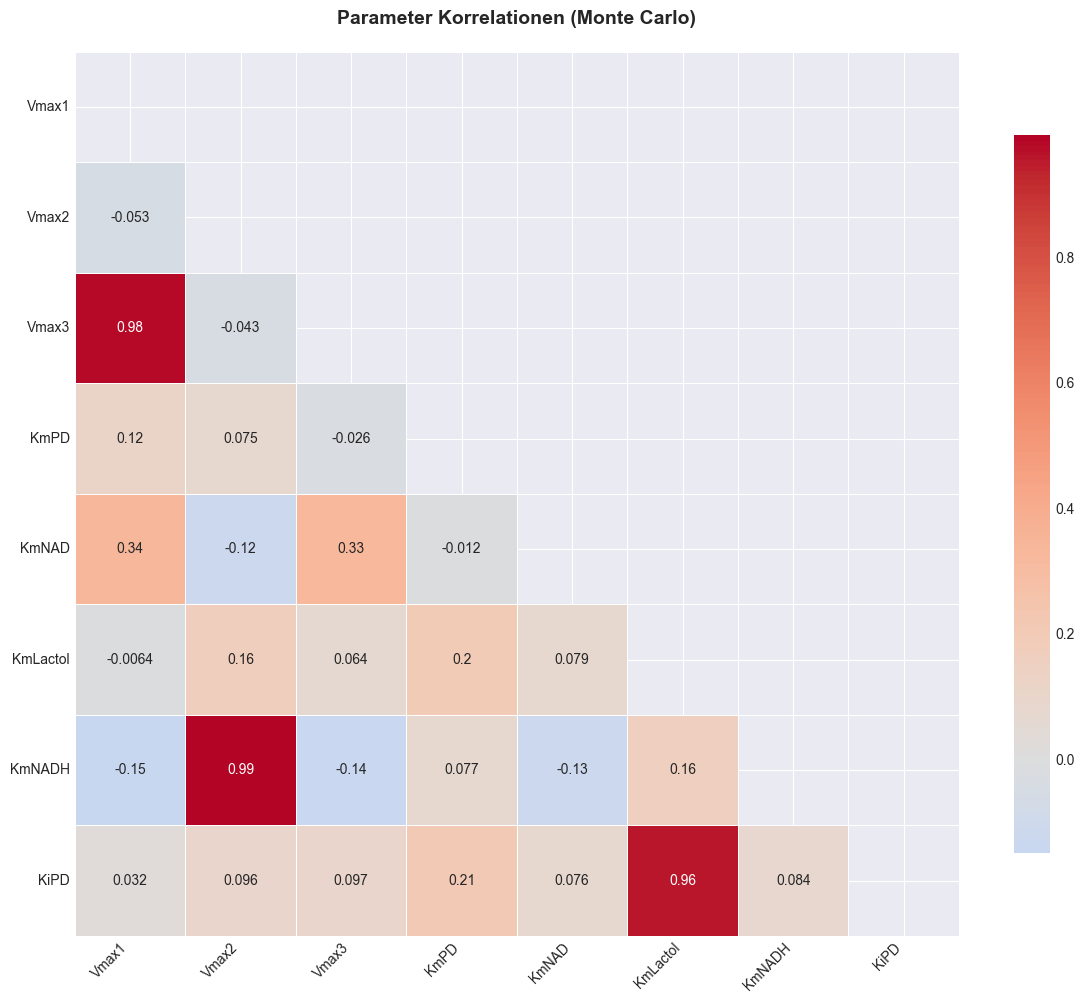

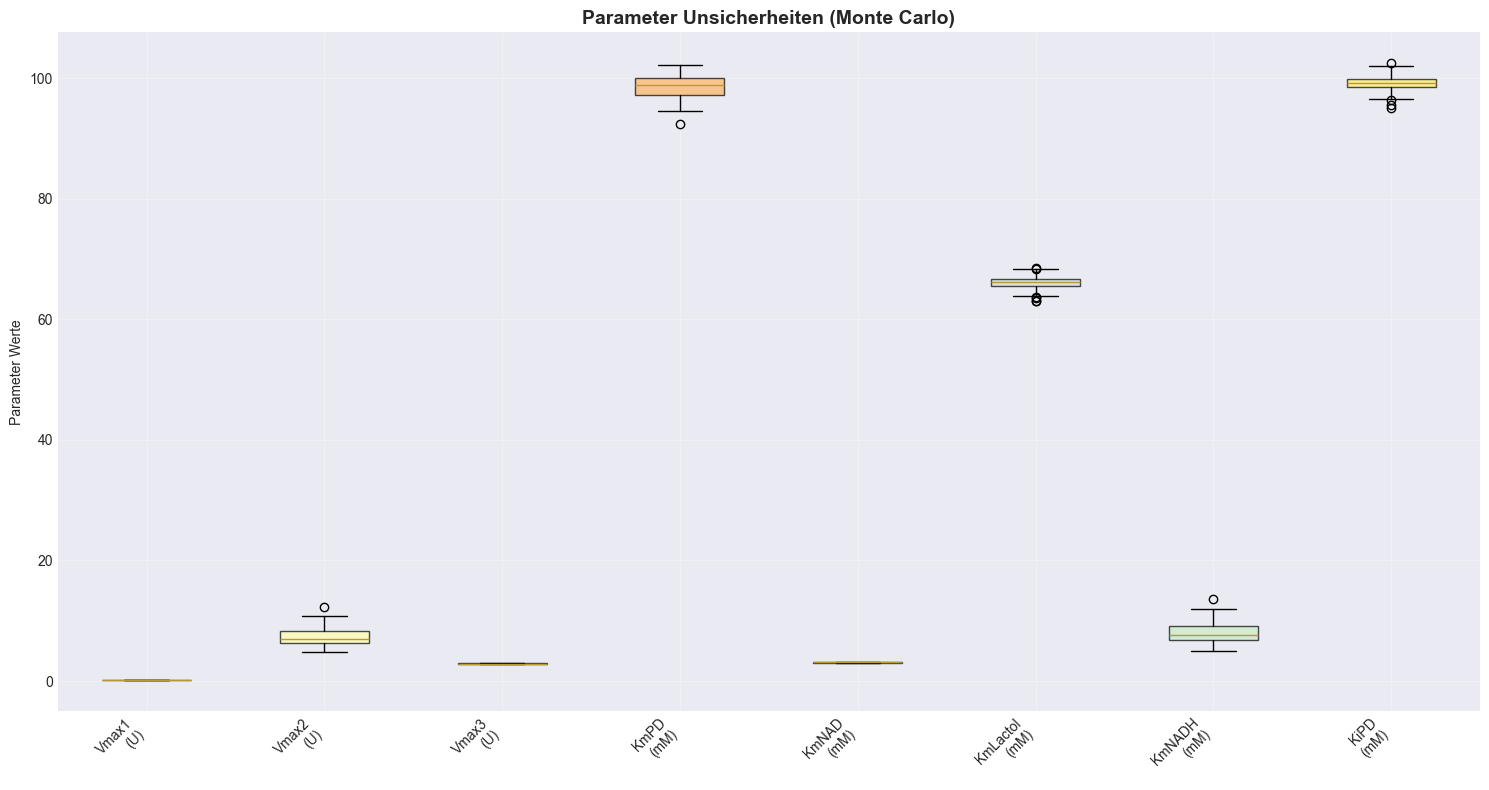

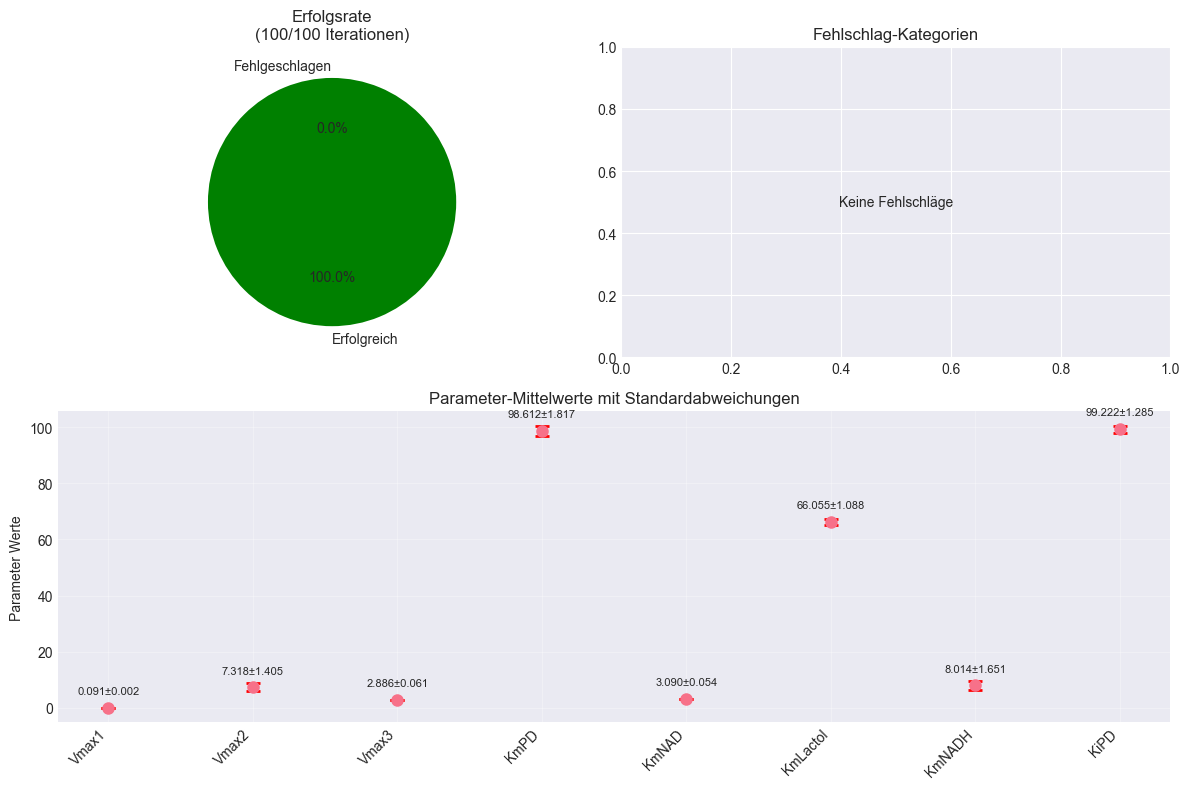

In [7]:
compare_parameter = {
    "Vmax1": 0.07,
    "Vmax2": 2.26,
    "Vmax3": 2.3,
    "KmPD": 84,
    "KmNAD": [2.2,2.8],
    "KmLactol": [111, 62],
    "KmNADH": 2.9,
    "KiPD": 90
}


plot_monte_carlo_results(monte_carlo_results,full_reaction_system_model_info,show_plots=True)

# 4.2 Ergebnisse der Cadet Simulation